In [1]:
# data, system tools
import pandas as pd
import numpy as np
import os
import glob
import itertools

# multiprocessing
import multiprocessing as mp
from functools import partial

# stats
from statsmodels.stats import outliers_influence
import statsmodels.stats.multitest as multi
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statannot
import scipy
import scipy.stats

# R
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
bayesfactor = importr('BayesFactor')     # ToDo: get this to work again

# plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
data_long = pd.read_csv('../data/final_data/AHEAD_and_CRUISE_and_ICV-combined-long.csv')
data_long = data_long.loc[data_long.Measure.isin(['IQR_intensity', 'Median_intensity'])]
data_long['Statistic'] = data_long.Measure.apply(lambda x: x.split('_')[0])
data_long = data_long.loc[data_long.Intensity.isin(['iron', 'myelin', 'thickness'])]
data_long = data_long.loc[~data_long.ROI2.isin(['Cerebellum', 'Cortex'])]
data_long

,Intensity,Measure,Segmentation,Age,Sexe,icv,ROI,Value,ROI2,hemisphere,tissue_type,Statistic
0,iron,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,4.537081,STR,L,GM,IQR
1,myelin,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,2.345612,STR,L,GM,IQR
6,thickness,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,3.998104,STR,L,GM,IQR
8,iron,Median_intensity,sub-000,22.0,f,1408505.6,STR L,6.543031,STR,L,GM,Median
9,myelin,Median_intensity,sub-000,22.0,f,1408505.6,STR L,7.155558,STR,L,GM,Median
...,...,...,...,...,...,...,...,...,...,...,...,...
68335,myelin,IQR_intensity,sub-109,23.0,f,1363826.2,CL R,3.871324,CL,R,GM,IQR
68340,thickness,IQR_intensity,sub-109,23.0,f,1363826.2,CL R,1.035591,CL,R,GM,IQR
68342,iron,Median_intensity,sub-109,23.0,f,1363826.2,CL R,2.439487,CL,R,GM,Median
68343,myelin,Median_intensity,sub-109,23.0,f,1363826.2,CL R,9.652806,CL,R,GM,Median


In [4]:
data_long = data_long.sort_values(['Measure', 'Segmentation', 'Intensity', 'ROI'])
data_long.ROI.unique()

array(['3V', '4V', 'AMG L', 'AMG R', 'CL L', 'CL R', 'GPe L', 'GPe R',
       'GPi L', 'GPi R', 'LV L', 'LV R', 'PAG L', 'PAG R', 'PPN L',
       'PPN R', 'RN L', 'RN R', 'SN L', 'SN R', 'STN L', 'STN R', 'STR L',
       'STR R', 'THA L', 'THA R', 'VTA L', 'VTA R', 'fx', 'ic L', 'ic R'],
      dtype=object)

## Final version

In [10]:
ROI_order = ['AMG L', 'AMG R', 
             'CL L', 'CL R', 
             'fx',
             'GPe L', 'GPe R',
             'GPi L', 'GPi R',
             'ic L', 'ic R',
             'PAG L', 'PAG R',
             'PPN L', 'PPN R',
             'RN L', 'RN R',
             'SN L', 'SN R',
             'STN L', 'STN R',
             'STR L', 'STR R',
             'THA L', 'THA R',
             'VTA L', 'VTA R',
             'LV L', 'LV R',
             '3V', '4V',
             ]

In [11]:
def bootstrap(data, n_iter=10000):
    
    all_out = []
    for i in range(n_iter):
        sample = np.random.choice(data, size=data.shape[0], replace=True)
        all_out.append(np.median(sample))
        
    return np.array(all_out)

def get_median_ci(data, n_iter=10000):
    bootstrap_iters = bootstrap(data, n_iter=n_iter)
    return np.array([np.percentile(bootstrap_iters, 2.5), np.percentile(bootstrap_iters, 97.5)])

In [9]:
CIs = data_long.groupby(['ROI', 'Intensity', 'Statistic'])['Value'].apply(lambda x: get_median_ci(x, 10000))
medians = data_long.groupby(['ROI', 'Intensity', 'Statistic'])['Value'].apply(lambda x: np.median(x))

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


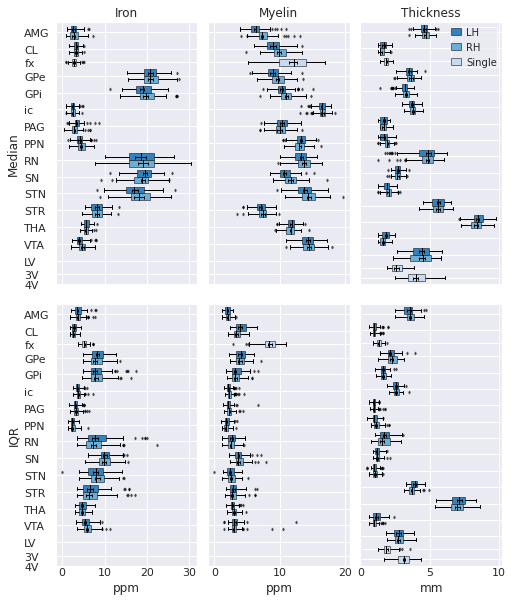

In [12]:
### Error bars
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(2,3, figsize=(8,10), sharey=False, sharex='col', gridspec_kw={'wspace': 0.075, 'hspace': 0.075})


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_y, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_x, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(ROI_order): #enumerate(data_long.ROI.unique()):
            if ROI.endswith(' L'):
                position += width+.26
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.26
                color = cmap(norm(3))
            all_positions[ROI] = position
            
            if ('LV ' in ROI or '3V' in ROI or '4V' in ROI) and not intensity == 'thickness':
                continue

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            values = values[pd.notnull(values)]  # one observation has no median thickness for STN L
            errbars = np.abs(CIs-medians).loc[ROI,intensity,statistic]
            bplot = ax[ax_x,ax_y].boxplot(values, notch=False, bootstrap=1000, 
                                          boxprops={'linewidth':0.5}, positions=[position], 
                                          patch_artist = True, widths=[width], vert=False, zorder=1)
            ax[ax_x, ax_y].errorbar(x=medians.loc[ROI,intensity,statistic], y=position, xerr=errbars[:,np.newaxis], 
                                    linewidth=1, color='black', linestyle='--', capsize=width*3, zorder=2)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
            

        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels(labelpos.index, ha = 'left')
            ax[ax_x,ax_y].set_ylabel(statistic)
        if ax_y > 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels([])
        ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-5)
        ax[ax_x,ax_y].invert_yaxis()
        
        if ax_x == 0:
            ax[ax_x,ax_y].set_title(intensity.capitalize()) #, fontdict={'fontsize': 14})

        # Axis labels
        if ax_x == 1:
            unit = 'ppm' if intensity in ['iron', 'myelin'] else 'mm'
            ax[ax_x, ax_y].set_xlabel('{}'.format(unit))
            

ax[0,2].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], 
               ['LH', 'RH', 'Single'], borderaxespad=.5, borderpad=0,
               labelspacing=.5, handlelength=1, handletextpad=0.5, edgecolor='white', fontsize='small')
# sns.despine()


plt.draw()  # this is needed because get_window_extent needs a renderer to work
yax = ax[0,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

yax = ax[1,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

f.savefig('../figures/figure1_boxplots_v6.pdf', bbox_inches='tight')

##### old stuff below

## Early attempts

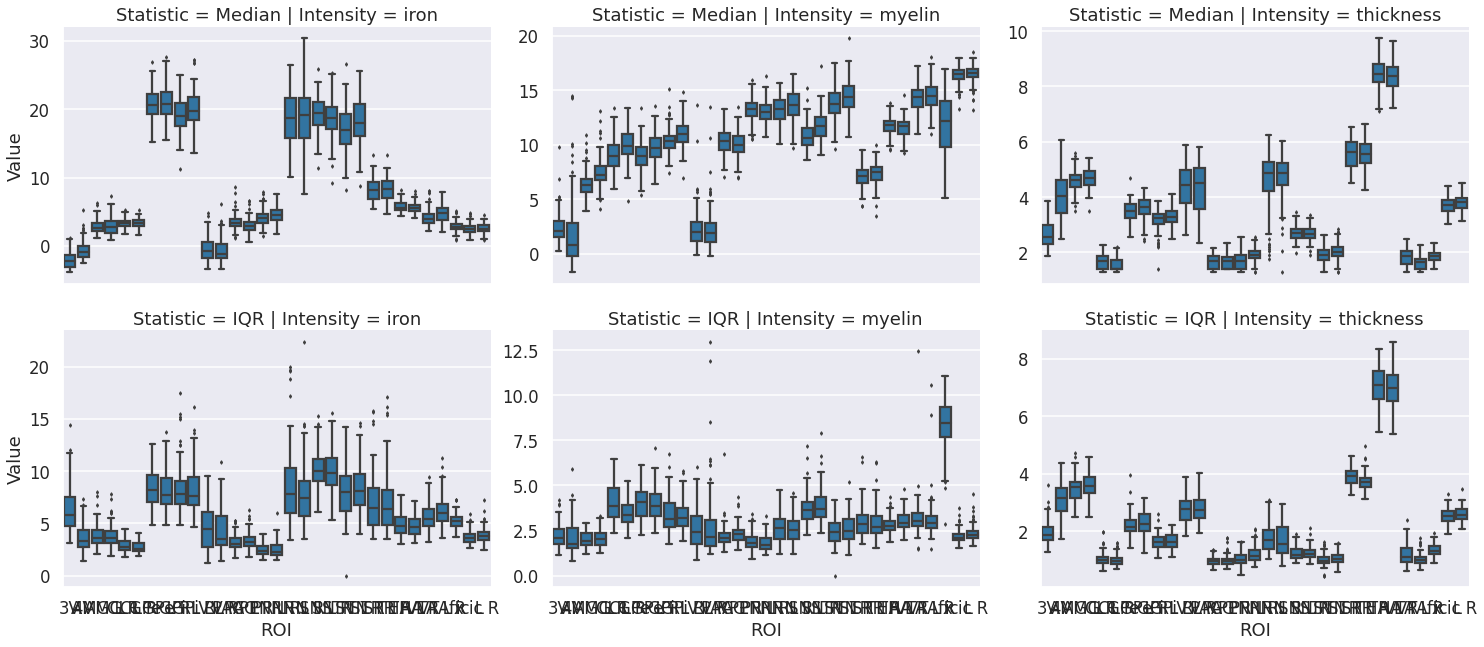

In [107]:
width = 7
aspect = 1.5
sns.set_context('talk')
fac = sns.FacetGrid(data=data_long, col='Intensity', row='Statistic', row_order=['Median', 'IQR'], 
                    sharex=True, sharey=False, height=width/aspect, aspect=aspect, despine=True)
# fac.map(plt.axhline, y=0, linestyle='--')
fac.map(sns.boxplot, 'ROI', 'Value', fliersize=2.5, order=data_long['ROI'].unique())

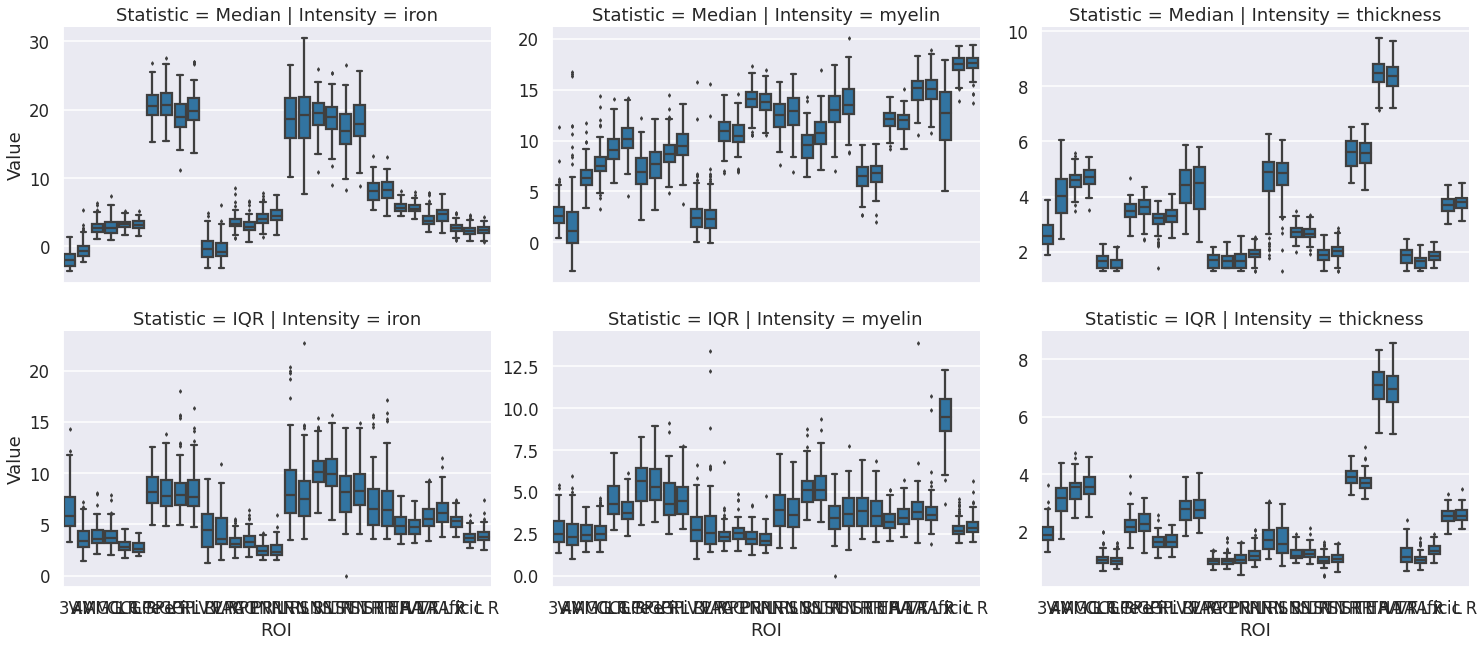

In [52]:
# OLD
width = 7
aspect = 1.5
sns.set_context('talk')
fac = sns.FacetGrid(data=data_long, col='Intensity', row='Statistic', row_order=['Median', 'IQR'], 
                    sharex=True, sharey=False, height=width/aspect, aspect=aspect, despine=True)
# fac.map(plt.axhline, y=0, linestyle='--')
fac.map(sns.boxplot, 'ROI', 'Value', fliersize=2.5, order=data_long['ROI'].unique())

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1211: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1218: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1226: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1227: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning:

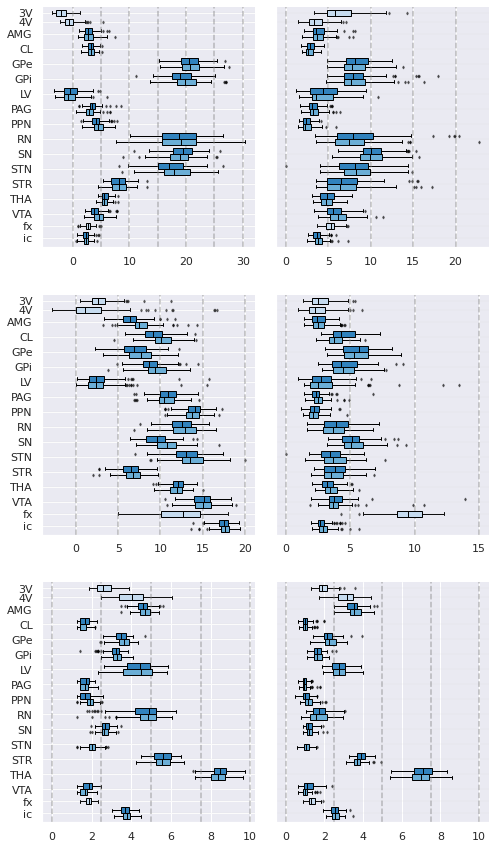

In [53]:
sns.set_context('notebook')
f, ax = plt.subplots(3,2, figsize=(8,15), sharey=False, sharex=False, gridspec_kw={'wspace': 0.1})


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5

for ax_n, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_y, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(data_long.ROI.unique()):
            if 'VENT' in ROI and not intensity == 'thickness':
                continue
            if ROI.endswith(' L'):
                position += width+.25
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.25
                color = cmap(norm(3))
            all_positions[ROI] = position

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            bplot = ax[ax_n,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
#             bps[intensity][statistic]['f'].append(ax[ax_n,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False))

    #         # M
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='m'), 'Value']
    #         bps[intensity][statistic]['m'].append(ax[ax_n].boxplot(values, notch=False, positions=[position+width/2], patch_artist = True, widths=[width/2]))

        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_n,ax_y].set_yticks(labelpos)
            ax[ax_n,ax_y].set_yticklabels(labelpos.index)
        if ax_y == 1:
            ax[ax_n,ax_y].set_yticks([])
            ax[ax_n,ax_y].set_yticklabels([])
        _ = [ax[ax_n,ax_y].axhline(x, alpha=0.1, color='lightgrey') for x in labelpos]

        if intensity == 'iron':
            if statistic == 'IQR':
                lines = np.arange(0,21,5)
            else:
                lines = np.arange(0,31,5)
        elif intensity == 'myelin':
            if statistic == 'IQR':
                lines = np.arange(0,16,5)
            else:
                lines = np.arange(0,21,5)
        else:
            lines = np.arange(0,11,2.5)
        
        _ = [ax[ax_n,ax_y].axvline(x, color='grey', linestyle = '--', alpha = 0.5) for x in lines]
        ax[ax_n,ax_y].invert_yaxis()

sns.despine()
# f.savefig('../figures/boxplots_test.pdf', bbox_inches='tight')

## Label in center?

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1211: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1218: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1226: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1227: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning:

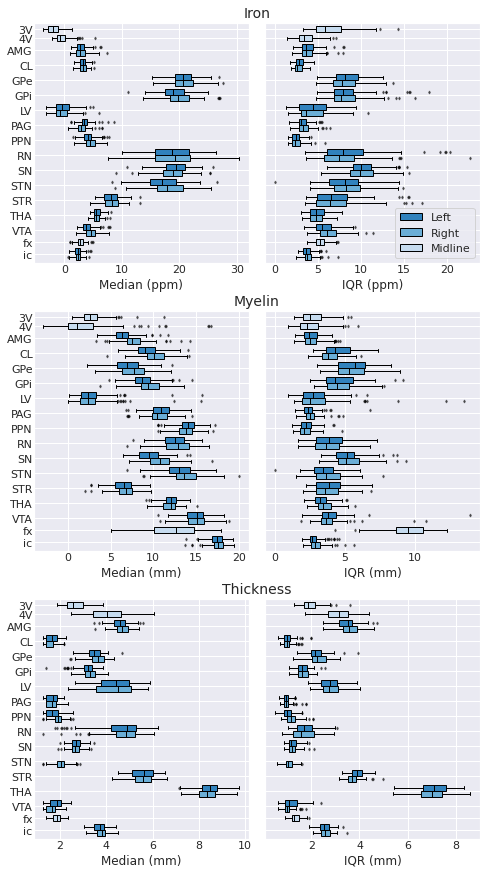

In [54]:
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(3,2, figsize=(8,15), sharey=False, sharex=False, gridspec_kw={'wspace': 0.075})

cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_n, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_y, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(data_long.ROI.unique()):
            if 'VENT' in ROI and not intensity == 'thickness':
                continue
            if ROI.endswith(' L'):
                position += width+.25
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.25
                color = cmap(norm(3))
            all_positions[ROI] = position

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            bplot = ax[ax_n,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
        
        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_n,ax_y].set_yticks(labelpos)
            ax[ax_n,ax_y].set_yticklabels(labelpos.index)
        if ax_y == 1:
            ax[ax_n,ax_y].set_yticks(labelpos)
            ax[ax_n,ax_y].set_yticklabels([])
        ax[ax_n,ax_y].tick_params(axis='both', which='major', pad=-5)
        ax[ax_n,ax_y].invert_yaxis()
        
        # Axis labels
        unit = 'ppm' if intensity in ['iron', 'median'] else 'mm'
        ax[ax_n, ax_y].set_xlabel('{} ({})'.format(statistic, unit))
        
        # add subplot with title
        if(ax_y == 0):
            ax_ = f.add_subplot(3,1,ax_n+1)
            ax_.axis('off')
            ax_.set_title(intensity.capitalize(), fontdict={'fontsize': 14})

ax[0,1].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], ['Left', 'Right', 'Midline'])
# sns.despine()
# f.savefig('../figures/boxplots_test2.pdf', bbox_inches='tight')

## one final shot at horizontal?


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1211: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1218: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1226: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1227: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning:

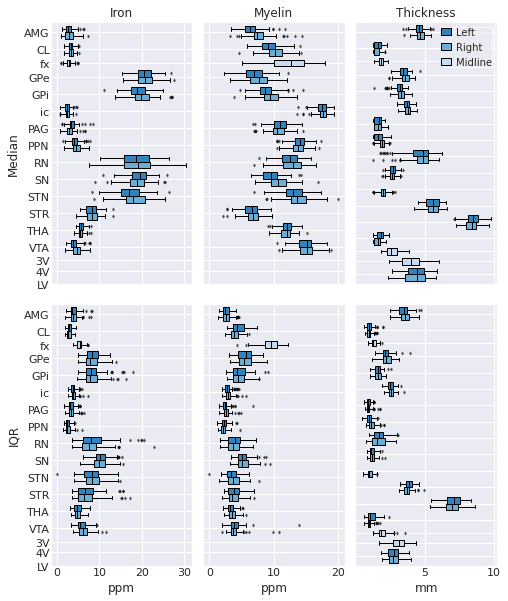

In [25]:
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(2,3, figsize=(8,10), sharey=False, sharex='col', gridspec_kw={'wspace': 0.075, 'hspace': 0.075})


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_y, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_x, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(data_long.ROI.unique()):
            if ROI.endswith(' L'):
                position += width+.25
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.25
                color = cmap(norm(3))
            all_positions[ROI] = position
            
            if 'VENT' in ROI and not intensity == 'thickness':
                continue

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            bplot = ax[ax_x,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
        
        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels(labelpos.index)
            ax[ax_x,ax_y].set_ylabel(statistic)
        if ax_y > 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels([])
        ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-5)
        ax[ax_x,ax_y].invert_yaxis()
        
        if ax_x == 0:
            ax[ax_x,ax_y].set_title(intensity.capitalize()) #, fontdict={'fontsize': 14})

        # Axis labels
        if ax_x == 1:
            unit = 'ppm' if intensity in ['iron', 'myelin'] else 'mm'
            ax[ax_x, ax_y].set_xlabel('{}'.format(unit))
        
#         # add subplot with title
#         if(ax_n == 0):
#             ax_ = f.add_subplot(3,1,ax_n+1)
#             ax_.axis('off')
#             ax_.set_title(intensity.capitalize(), fontdict={'fontsize': 14})

ax[0,2].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], 
               ['Left', 'Right', 'Midline'], borderaxespad=.5, borderpad=0,
               labelspacing=.5, handlelength=1, handletextpad=0.5, edgecolor='white', fontsize='small')
# sns.despine()

# f.savefig('../figures/figure1_boxplots_v3.pdf', bbox_inches='tight')

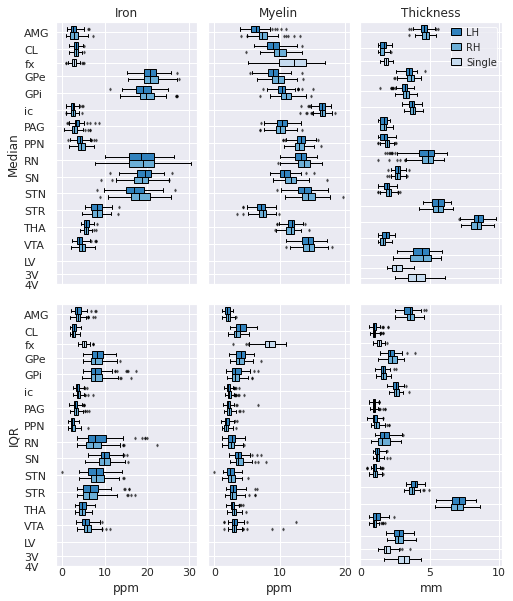

In [6]:
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(2,3, figsize=(8,10), sharey=False, sharex='col', gridspec_kw={'wspace': 0.075, 'hspace': 0.075})


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_y, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_x, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(ROI_order): #enumerate(data_long.ROI.unique()):
            if ROI.endswith(' L'):
                position += width+.25
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.25
                color = cmap(norm(3))
            all_positions[ROI] = position
            
            if ('LV ' in ROI or '3V' in ROI or '4V' in ROI) and not intensity == 'thickness':
                continue

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            values = values[pd.notnull(values)]  # one observation has no median thickness for STN L
            bplot = ax[ax_x,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
        
        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels(labelpos.index, ha = 'left')
            ax[ax_x,ax_y].set_ylabel(statistic)
        if ax_y > 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels([])
        ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-5)
        ax[ax_x,ax_y].invert_yaxis()
        
        if ax_x == 0:
            ax[ax_x,ax_y].set_title(intensity.capitalize()) #, fontdict={'fontsize': 14})

        # Axis labels
        if ax_x == 1:
            unit = 'ppm' if intensity in ['iron', 'myelin'] else 'mm'
            ax[ax_x, ax_y].set_xlabel('{}'.format(unit))
            

ax[0,2].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], 
               ['LH', 'RH', 'Single'], borderaxespad=.5, borderpad=0,
               labelspacing=.5, handlelength=1, handletextpad=0.5, edgecolor='white', fontsize='small')
# sns.despine()


plt.draw()  # this is needed because get_window_extent needs a renderer to work
yax = ax[0,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

yax = ax[1,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

f.savefig('../figures/figure1_boxplots_v4.pdf', bbox_inches='tight')

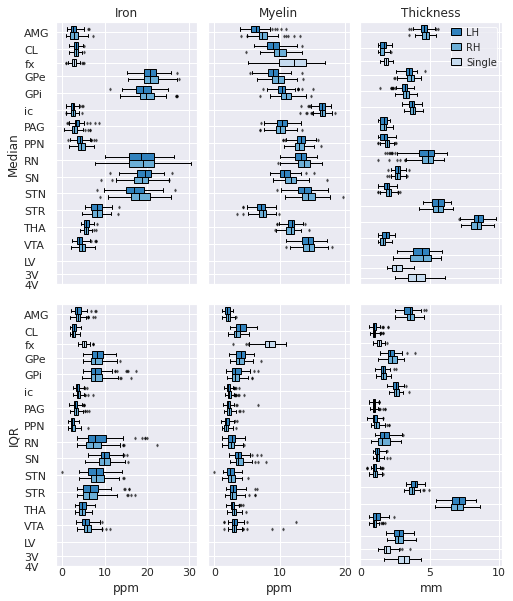

In [7]:
###
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(2,3, figsize=(8,10), sharey=False, sharex='col', gridspec_kw={'wspace': 0.075, 'hspace': 0.075})


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_y, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_x, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(ROI_order): #enumerate(data_long.ROI.unique()):
            if ROI.endswith(' L'):
                position += width+.25
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.25
                color = cmap(norm(3))
            all_positions[ROI] = position
            
            if ('LV ' in ROI or '3V' in ROI or '4V' in ROI) and not intensity == 'thickness':
                continue

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            values = values[pd.notnull(values)]  # one observation has no median thickness for STN L
            bplot = ax[ax_x,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
        
        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels(labelpos.index, ha = 'left')
            ax[ax_x,ax_y].set_ylabel(statistic)
        if ax_y > 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels([])
        ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-5)
        ax[ax_x,ax_y].invert_yaxis()
        
        if ax_x == 0:
            ax[ax_x,ax_y].set_title(intensity.capitalize()) #, fontdict={'fontsize': 14})

        # Axis labels
        if ax_x == 1:
            unit = 'ppm' if intensity in ['iron', 'myelin'] else 'mm'
            ax[ax_x, ax_y].set_xlabel('{}'.format(unit))
            

ax[0,2].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], 
               ['LH', 'RH', 'Single'], borderaxespad=.5, borderpad=0,
               labelspacing=.5, handlelength=1, handletextpad=0.5, edgecolor='white', fontsize='small')
# sns.despine()


plt.draw()  # this is needed because get_window_extent needs a renderer to work
yax = ax[0,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

yax = ax[1,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

f.savefig('../figures/figure1_boxplots_v5.pdf', bbox_inches='tight')

In [2]:
from nilearn import plotting
def draw_custom_colorbar(colorbar_ax, vmin=3, vmax=6, truncation_limits=(0,6), offset=4., nb_ticks=4, flip=True,
                         format="%.1f", cmap=plotting.cm.cold_hot, tick_left=True, tick_right=False, is_symmetric=True,
                         orientation='vertical', label=''):
    from matplotlib.colorbar import ColorbarBase
    from matplotlib import colors
    our_cmap = cmap
    if flip:
        truncation_limits = [truncation_limits[1], truncation_limits[0]]
    
    if nb_ticks > 0:
        ticks = np.linspace(truncation_limits[0], truncation_limits[1], nb_ticks)
    else:
        ticks = []
    bounds = np.linspace(truncation_limits[0], truncation_limits[1], our_cmap.N)
    if is_symmetric:
        norm = colors.Normalize(vmin=-vmax, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    
    # some colormap hacking
    cmaplist = [our_cmap(i) for i in range(our_cmap.N)]
    istart = int(norm(-offset, clip=True) * (our_cmap.N - 1))
    istop = int(norm(offset, clip=True) * (our_cmap.N - 1))
    for i in range(istart, istop):
        cmaplist[i] = (0.5, 0.5, 0.5, 1.)  # just an average gray color
    our_cmap = our_cmap.from_list('Custom cmap', cmaplist, our_cmap.N)

    ColorbarBase(colorbar_ax, ticks=ticks, norm=norm,
                 orientation=orientation, cmap=our_cmap, boundaries=bounds,
                 spacing='proportional', format=format, label=label)
    
    if flip:
        colorbar_ax.invert_yaxis()
    if tick_left:
        colorbar_ax.yaxis.tick_left()
    if tick_right:
        colorbar_ax.yaxis.tick_right()

    return colorbar_ax

In [3]:
pretty_names_map = {
    'AMG': 'Amygdala',
    'CL': 'Claustrum',
    'FX': 'Fornix',
    'Cerebellum': 'Cerebellum',
    'Cortex': 'Cortex',
    'GPE': 'Globus pallidus externa',
    'GPI': 'Globus pallidus interna',
    'IC': 'Internal capsule',
    'LVENT': 'Ventricles (lateral)',
    'PAG': 'Periaquaductal gray',
    'PPN': 'Pedunculopontine nucleus',
    'RN': 'Red nucleus',
    'SN': 'Substantia nigra',
    'STN': 'Subthalamic nucleus',
    'STR': 'Striatum',
    'THA': 'Thalamus',
    'VENT3': 'Ventricle 3',
    'VENT4': 'Ventricle 4',
    'VTA': 'Ventral tegmental area',
}

In [24]:
# Load data
final_table_absolute = pd.read_pickle('../data/interim_data/summary_table_qmri_absolute.pkl')
final_table_location = pd.read_pickle('../data/interim_data/summary_table_location.pkl')*2  # multiply because the models are in 0.5mm space, so scale becomes mm
final_table_location.columns = final_table_location.columns.droplevel([0])
final_table_absolute = pd.merge(final_table_location, final_table_absolute, left_index=True, right_index=True, how='outer')

final_table_absolute = final_table_absolute.iloc[:,[4,3,6,5,8,7, 0, 1, 2]]
final_table_absolute = final_table_absolute.iloc[[0,1,4,5,6,7,9,10,11,12,13,14,15,8,16,17,18],:] # remove cortex cerebellum, move ventricles together

# Remove FX location: these aren't reliable
final_table_absolute.loc['FX', 'location'] = 0


final_table_proportional = pd.read_pickle('../data/interim_data/summary_table_qmri_proportional.pkl')
final_table_proportional

final_table_proportional = final_table_proportional.iloc[:,[1,0,3,2,5,4]]
final_table_proportional = final_table_proportional.iloc[[0,1,4,5,6,7,9,10,11,12,13,14,15,8,16,17,18],:] # remove cortex cerebellum, move ventricles together
final_table_proportional

qMRI        iron        myelin        thickness       
Statistic median    iqr median    iqr    median    iqr
ROI                                                   
AMG        0.627  0.318 -0.062  0.354     0.000  0.052
CL         0.000  0.395 -0.101  0.319     0.000  0.000
FX         0.338  0.185 -0.312  0.297    -0.074  0.000
GPE        0.113  0.489 -0.295  0.506    -0.137 -0.168
GPI        0.000  0.207  0.000  0.445    -0.124  0.131
IC         0.103  0.249 -0.099  0.375     0.000  0.025
PAG        0.104  0.134 -0.083  0.100     0.145  0.126
PPN        0.094  0.254 -0.063  0.057     0.000  0.000
RN         0.729  1.279 -0.222  0.815    -0.220  0.434
SN         0.195  0.161  0.000  0.257     0.000  0.183
STN        0.242 -0.258 -0.113  0.287     0.000  0.000
STR        0.504  1.361 -0.290  0.932    -0.203  0.068
THA       -0.258  0.459 -0.036  0.382    -0.046  0.101
LVENT     -3.103 -0.420  0.000  0.000     0.290  0.139
VENT3      0.727 -0.349  0.000 -0.290     0.313  0.187
VENT4     -0.931  0.000  0.000  0.337     0.000  0.000
VTA        0.334  0.255 -0.151  0.000     0.148  0.164

In [7]:
def get_cell_colors(table, cmap, max_value, vmax=256, vmin=0):
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
        
    def norm(x, x_max=max_value, vmax=vmax, vmin=vmin):
        return int(vmax/2 + (x/x_max)*(vmax-vmin)/2)

    def get_hex(value, cmap, **kwargs):
        rgb = cmap(norm(value, **kwargs))[:3]   # no alpha
        return matplotlib.colors.rgb2hex(rgb)

    # make RGB table
    color_table_rgb = np.empty((table.shape[0], table.shape[1], 3))
    color_table_hex = table.copy()
    for row in range(table.shape[0]):
        for col in range(table.shape[1]):
            x = get_hex(table.iloc[row, col], cmap=cmap)
            color_table_hex.iloc[row, col] = x
            color_table_rgb[row, col, :] = cmap(norm(table.iloc[row, col]))[:3]
    return color_table_rgb

## Single plot, for absolute?

Text(7, -1.5, 'Location')

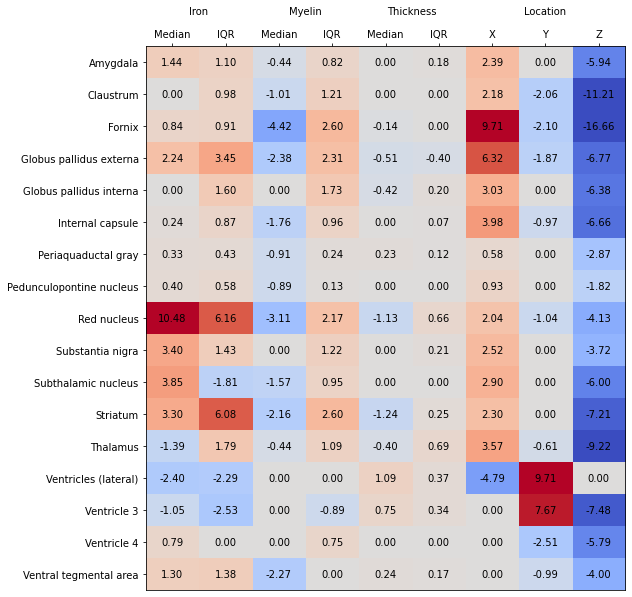

In [8]:
color_table_rgb = get_cell_colors(final_table_absolute, cmap='coolwarm', max_value=8)

# combine in plot of table
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(color_table_rgb, aspect=0.6)

for i in range(len(final_table_absolute)):
    for j in range(len(final_table_absolute.columns)):
        ax.text(j, i, '{:.2f}'.format(final_table_absolute.values[i, j]),
                ha="center", va="center", color='black')
ax.set_yticks(ticks=np.arange(final_table_absolute.shape[0]))
ax.set_xticks(ticks=np.arange(final_table_absolute.shape[1]))
ax.set_xticklabels([x[-1].title() if x[-1]=='median' else 'IQR' if x[-1] == 'iqr' else x[1][0].upper() for x in final_table_absolute.columns])
ax.set_yticklabels([pretty_names_map[x] for x in final_table_absolute.index.values if x in pretty_names_map.keys()])
ax.xaxis.tick_top()
ax.text(0.5, -1.5, 'Iron', ha='center')
ax.text(2.5, -1.5, 'Myelin', ha='center')
ax.text(4.5, -1.5, 'Thickness', ha='center')
ax.text(7, -1.5, 'Location', ha='center')
#fig.savefig('./table_tmp.pdf', bbox_inches='tight')

## Single plot for absolute, separate colormaps per "Change type"

In [11]:
plot_dict = {'medians': [10, [0,2], 'ppm'],
             'IQRs': [5, [1,3], 'ppm'],
             'thickness': [1.5, [4,5], 'mm'],
             'location': [15, [6,7,8], 'mm']
             }

colorbar_grid_offset = 0.2
title_label_map = {'median': 'M',
                   'iqr': 'IQR',
                   'X_mni_abs': 'M-L',
                   'Y_mni': 'A-P',
                   'Z_mni': 'I-S'}

In [31]:
!pwd

/home/stevenm/Projects/Ahead_statistics/code


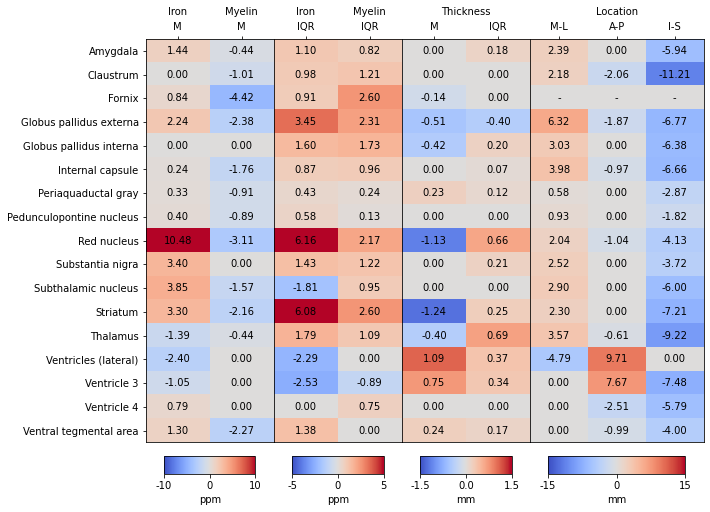

In [29]:
## Grid should be 4 wide, at least 2 high (colorbars below!)
fig = plt.Figure(figsize=(10,8))
width_ratios = np.array([colorbar_grid_offset, 1, colorbar_grid_offset, 
                         colorbar_grid_offset, 1, colorbar_grid_offset,
                         colorbar_grid_offset, 1, colorbar_grid_offset,
                         colorbar_grid_offset, 1.5, colorbar_grid_offset])
width_ratios /= width_ratios.sum()
#width_ratios
gs = plt.GridSpec(3, width_ratios.shape[0], figure=fig, 
                  width_ratios=width_ratios, hspace=0.1, wspace=0,
                  height_ratios=[0.1, 1, .05])

ax = []
for c, (column, (max_value, column_ilocs, label)) in enumerate(plot_dict.items()):
    c = c*3+1
    ax.append(fig.add_subplot(gs[:2,(c-1):(c+2)]))

    this_table = final_table_absolute.iloc[:,column_ilocs]
    color_table_rgb = get_cell_colors(this_table, cmap='coolwarm', max_value=max_value)

    # combine in plot of table
    ax[-1].imshow(color_table_rgb, aspect='auto')
    for i in range(len(this_table)):
        for j in range(len(this_table.columns)):
            if column == 'location' and i == 2:  # FX location should be '-'
                ax[-1].text(j, i, '-',
                        ha="center", va="center", color='black')
            else:
                ax[-1].text(j, i, '{:.2f}'.format(this_table.values[i, j]),
                        ha="center", va="center", color='black')
    if c > 3:
        ax[-1].set_yticks([])
    else:
        ax[-1].set_yticks(ticks=np.arange(this_table.shape[0]))
        ax[-1].set_yticklabels([pretty_names_map[x] for x in this_table.index.values if x in pretty_names_map.keys()])
        
    ax[-1].set_xticks(ticks=np.arange(this_table.shape[1]))
    ax[-1].set_xticklabels([title_label_map[x[-1]] for x in this_table.columns])
    ax[-1].xaxis.tick_top()
    
    cbar_ax1 = draw_custom_colorbar(colorbar_ax=fig.add_subplot(gs[2,c]), truncation_limits=(-max_value,max_value), 
                                vmin=-max_value, vmax=max_value, nb_ticks=3,
                                offset=0, flip=False, cmap=plt.get_cmap('coolwarm'), 
                                format='%.1f' if max_value == 1.5 else '%d',
                                orientation='horizontal', label=label)
# def highlight_cell(x,y, ax=None, **kwargs):
#     rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=True, **kwargs)
#     ax = ax or plt.gca()
#     ax.add_patch(rect)
#     return rect
# highlight_cell(0,2,ax[-1], color='grey')
# highlight_cell(1,2,ax[-1], color='grey')
# highlight_cell(2,2,ax[-1], color='grey')

ax[0].text(0, -1.5, 'Iron', ha='center')
ax[1].text(0, -1.5, 'Iron', ha='center')
ax[0].text(1, -1.5, 'Myelin', ha='center')
ax[1].text(1, -1.5, 'Myelin', ha='center')
# ax[1].text(0.5, -2.1, 'Tissue degradation', ha='center')
ax[2].text(0.5, -1.5, 'Thickness', ha='center')
ax[3].text(1, -1.5, 'Location', ha='center')
# ax[3].text(-0.5, -2.1, 'Atrophy', ha='center')

fig.savefig('./figure1.pdf', bbox_inches='tight')

fig


## Add changes proportional

In [100]:
plot_dict_absolute = {'medians': [10, [0,2], 'ppm/year'],
                      'IQRs': [5, [1,3], 'ppm/year'],
                      'thickness': [1.5, [4,5], 'mm/year'],
                      'location': [8, [6,7,8], 'mm/year']
                      }

plot_dict_proportional = {'medians': [1, [0,2], ''],
                          'IQRs': [1, [1,3], 'proportion/year'],
                          'thickness': [1, [4,5], '']
                          }


colorbar_grid_offset = 0.2

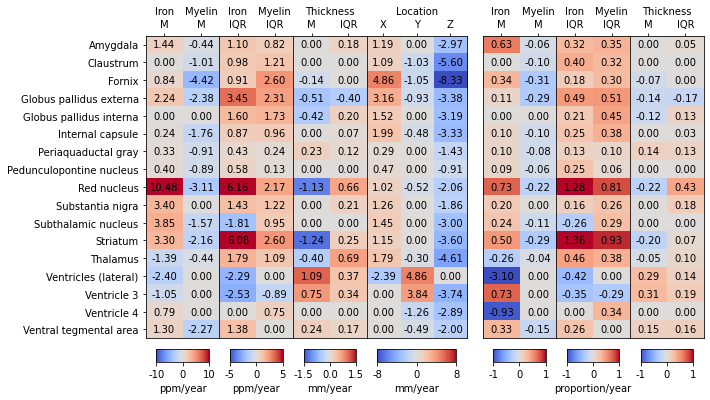

In [106]:
## Grid should be 4 wide, at least 2 high (colorbars below!)
fig = plt.Figure(figsize=(10,6))
width_ratios = np.array([colorbar_grid_offset, 1, colorbar_grid_offset, 
                         colorbar_grid_offset, 1, colorbar_grid_offset,
                         colorbar_grid_offset, 1, colorbar_grid_offset,
                         colorbar_grid_offset, 1.5, colorbar_grid_offset,
                         0.3,  # whitespace
                         colorbar_grid_offset, 1, colorbar_grid_offset, 
                         colorbar_grid_offset, 1, colorbar_grid_offset,
                         colorbar_grid_offset, 1, colorbar_grid_offset,
                         ])
width_ratios /= width_ratios.sum()
#width_ratios
gs = plt.GridSpec(3, width_ratios.shape[0], figure=fig, 
                  width_ratios=width_ratios, hspace=0.1, wspace=0,
                  height_ratios=[0.1, 1, .05])

ax = []
for c, (column, (max_value, column_ilocs, label)) in enumerate(plot_dict_absolute.items()):
    c = c*3+1
    ax.append(fig.add_subplot(gs[:2,(c-1):(c+2)]))

    this_table = final_table_absolute.iloc[:,column_ilocs]
    color_table_rgb = get_cell_colors(this_table, cmap='coolwarm', max_value=max_value)

    # combine in plot of table
    ax[-1].imshow(color_table_rgb, aspect='auto')
    for i in range(len(this_table)):
        for j in range(len(this_table.columns)):
            ax[-1].text(j, i, '{:.2f}'.format(this_table.values[i, j]),
                    ha="center", va="center", color='black')
    if c > 3:
        ax[-1].set_yticks([])
    else:
        ax[-1].set_yticks(ticks=np.arange(this_table.shape[0]))
        ax[-1].set_yticklabels([pretty_names_map[x] for x in this_table.index.values if x in pretty_names_map.keys()])
        
    ax[-1].set_xticks(ticks=np.arange(this_table.shape[1]))
    ax[-1].set_xticklabels(['M' if x[-1]=='median' else 'IQR' if x[-1] == 'iqr' else x[1][0].upper() for x in this_table.columns])
    ax[-1].xaxis.tick_top()
    
    cbar_ax1 = draw_custom_colorbar(colorbar_ax=fig.add_subplot(gs[2,c]), truncation_limits=(-max_value,max_value), 
                                vmin=-max_value, vmax=max_value, nb_ticks=3,
                                offset=0, flip=False, cmap=plt.get_cmap('coolwarm'), 
                                format='%.1f' if max_value == 1.5 else '%d',
                               orientation='horizontal', label=label)
y_offset = -1.7
ax[0].text(0, y_offset, 'Iron', ha='center')
ax[1].text(0, y_offset, 'Iron', ha='center')
ax[0].text(1, y_offset, 'Myelin', ha='center')
ax[1].text(1, y_offset, 'Myelin', ha='center')
#ax[1].text(0.5, -2.1, 'Tissue degradation', ha='center')
ax[2].text(0.5, y_offset, 'Thickness', ha='center')
ax[3].text(1, y_offset, 'Location', ha='center')
#ax[3].text(-0.5, -2.1, 'Atrophy', ha='center')

# 
for c, (column, (max_value, column_ilocs, label)) in enumerate(plot_dict_proportional.items()):
    c = c*3+14 # whitespace
    ax.append(fig.add_subplot(gs[:2,(c-1):(c+2)]))

    this_table = final_table_proportional.iloc[:,column_ilocs]
    color_table_rgb = get_cell_colors(this_table, cmap='coolwarm', max_value=max_value)

    # combine in plot of table
    ax[-1].imshow(color_table_rgb, aspect='auto')
    for i in range(len(this_table)):
        for j in range(len(this_table.columns)):
            ax[-1].text(j, i, '{:.2f}'.format(this_table.values[i, j]),
                    ha="center", va="center", color='black')
    if c > 3:
        ax[-1].set_yticks([])
    else:
        ax[-1].set_yticks(ticks=np.arange(this_table.shape[0]))
        ax[-1].set_yticklabels([pretty_names_map[x] for x in this_table.index.values if x in pretty_names_map.keys()])
        
    ax[-1].set_xticks(ticks=np.arange(this_table.shape[1]))
    ax[-1].set_xticklabels(['M' if x[-1]=='median' else 'IQR' if x[-1] == 'iqr' else x[1][0].upper() for x in this_table.columns])
    ax[-1].xaxis.tick_top()
    
    cbar_ax1 = draw_custom_colorbar(colorbar_ax=fig.add_subplot(gs[2,c]), truncation_limits=(-max_value,max_value), 
                                vmin=-max_value, vmax=max_value, nb_ticks=3,
                                offset=0, flip=False, cmap=plt.get_cmap('coolwarm'), 
                                format='%.1f' if max_value == 1.5 else '%d',
                                orientation='horizontal', label=label)

ax[4].text(0, y_offset, 'Iron', ha='center')
ax[5].text(0, y_offset, 'Iron', ha='center')
ax[4].text(1, y_offset, 'Myelin', ha='center')
ax[5].text(1, y_offset, 'Myelin', ha='center')
#ax[1].text(0.5, -2.1, 'Tissue degradation', ha='center')
ax[6].text(0.5, y_offset, 'Thickness', ha='center')
# ax[3].text(1, y_offset, 'Location', ha='center')

# ax[3].text(0, -1.5, 'Iron', ha='center')
# ax[4].text(0, -1.5, 'Iron', ha='center')
# ax[3].text(1, -1.5, 'Myelin', ha='center')
# ax[4].text(1, -1.5, 'Myelin', ha='center')
# ax[4].text(0.5, -2.1, 'Tissue degradation', ha='center')
# ax[3].text(0.5, -1.5, 'Thickness', ha='center')
# ax[3].text(1, -1.5, 'Location', ha='center')
# ax[3].text(-0.5, -2.1, 'Atrophy', ha='center')

fig.savefig('./table_tmp4.pdf', bbox_inches='tight')

fig


## Two tables next to each other with two colormaps

In [341]:
cmap1 = plt.get_cmap('coolwarm')

qMRI_table = final_table.iloc[:,:-3]
location_table = final_table.iloc[:,-3:]

def norm(x, x_max=1.5, vmax=256, vmin=0):
    return int(vmax/2 + (x/x_max)*(vmax-vmin)/2)

def get_hex(tsnr, cmap, **kwargs):
    rgb = cmap(norm(tsnr, **kwargs))[:3]   # no alpha
    return matplotlib.colors.rgb2hex(rgb)

color_table_rgb_qMRI = np.empty((qMRI_table.shape[0], qMRI_table.shape[1], 3))
color_table_hex_qMRI = qMRI_table.copy()
for row in range(qMRI_table.shape[0]):
    for col in range(qMRI_table.shape[1]):
        x = get_hex(qMRI_table.iloc[row, col], cmap=cmap1)
        color_table_hex_qMRI.iloc[row, col] = x
        color_table_rgb_qMRI[row, col, :] = cmap1(norm(qMRI_table.iloc[row, col]))[:3]
        
cmap2 = plt.get_cmap('coolwarm')

def norm(x, x_max=6, vmax=256, vmin=0):
    return int(vmax/2 + (x/x_max)*(vmax-vmin)/2)

def get_hex(tsnr, cmap, **kwargs):
    rgb = cmap(norm(tsnr, **kwargs))[:3]   # no alpha
    return matplotlib.colors.rgb2hex(rgb)

color_table_rgb_location = np.empty((location_table.shape[0], location_table.shape[1], 3))
color_table_hex_location = location_table.copy()
for row in range(location_table.shape[0]):
    for col in range(location_table.shape[1]):
        x = get_hex(location_table.iloc[row, col], cmap=cmap2)
        color_table_hex_location.iloc[row, col] = x
        color_table_rgb_location[row, col, :] = cmap2(norm(location_table.iloc[row, col]))[:3]

In [319]:
from nilearn import plotting
def draw_custom_colorbar(colorbar_ax, vmin=3, vmax=6, truncation_limits=(0,6), offset=4., nb_ticks=4, flip=True,
                         format="%.1f", cmap=plotting.cm.cold_hot, tick_left=True, tick_right=False, is_symmetric=True):
    from matplotlib.colorbar import ColorbarBase
    from matplotlib import colors
    our_cmap = cmap
    if flip:
        truncation_limits = [truncation_limits[1], truncation_limits[0]]
    
    if nb_ticks > 0:
        ticks = np.linspace(truncation_limits[0], truncation_limits[1], nb_ticks)
    else:
        ticks = []
    bounds = np.linspace(truncation_limits[0], truncation_limits[1], our_cmap.N)
    if is_symmetric:
        norm = colors.Normalize(vmin=-vmax, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    
    # some colormap hacking
    cmaplist = [our_cmap(i) for i in range(our_cmap.N)]
    istart = int(norm(-offset, clip=True) * (our_cmap.N - 1))
    istop = int(norm(offset, clip=True) * (our_cmap.N - 1))
    for i in range(istart, istop):
        cmaplist[i] = (0.5, 0.5, 0.5, 1.)  # just an average gray color
    our_cmap = our_cmap.from_list('Custom cmap', cmaplist, our_cmap.N)

    ColorbarBase(colorbar_ax, ticks=ticks, norm=norm,
                 orientation='vertical', cmap=our_cmap, boundaries=bounds,
                 spacing='proportional', format=format)
    
    if flip:
        colorbar_ax.invert_yaxis()
    if tick_left:
        colorbar_ax.yaxis.tick_left()
    if tick_right:
        colorbar_ax.yaxis.tick_right()

    return colorbar_ax

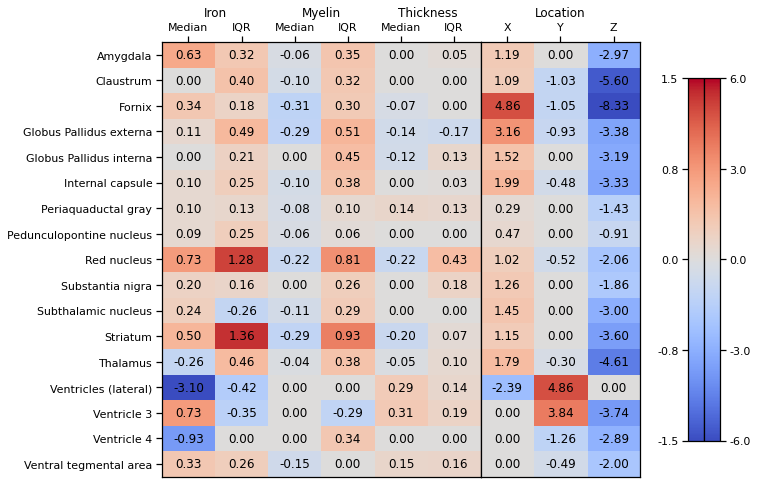

In [346]:
# combine in plot of table
fig = plt.Figure(figsize=(10,8))
width_ratios = np.array([1, 0.5, 0.15, .05, .05])
width_ratios /= width_ratios.sum()
#width_ratios
gs = plt.GridSpec(3, width_ratios.shape[0], figure=fig, 
                  width_ratios=width_ratios, hspace=0, wspace=0,
                  height_ratios=[0.1, 1, .1])

ax = []
ax.append(fig.add_subplot(gs[:,0]))
ax.append(fig.add_subplot(gs[:,1]))
ims = []
for index, (table, color_table) in enumerate(zip([qMRI_table, location_table], [color_table_rgb_qMRI, color_table_rgb_location])):
    if index == 0:
        aspect = 'auto'
    else:
        aspect = 'auto'
    ax_ = ax[index]
    ims.append(ax_.imshow(color_table, aspect=aspect, alpha=1))
    for i in range(len(table)):
        for j in range(len(table.columns)):
            ax_.text(j, i, '{:.2f}'.format(table.values[i, j]),
                       ha="center", va="center", color='black')
    ax_.set_yticks(ticks=np.arange(table.shape[0]))
    ax_.set_xticks(ticks=np.arange(table.shape[1]))
    ax_.set_xticklabels([x[-1].title() if x[-1]=='median' else 'IQR' if x[-1] == 'iqr' else x[1][0].upper() for x in table.columns])
    ax_.set_yticklabels([pretty_names_map[x] for x in table.index.values if x in pretty_names_map.keys()])
    ax_.xaxis.tick_top()

cbar_ax1 = draw_custom_colorbar(colorbar_ax=fig.add_subplot(gs[1,3]), truncation_limits=(-1.5,1.5), 
                                vmin=-1.5, vmax=1.5, nb_ticks=5,
                                offset=0, flip=False, cmap=cmap1)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=fig.add_subplot(gs[1,4]), 
                                truncation_limits=(-6,6),
                                vmin=-6, vmax=6, 
                                offset=0,
                                flip=False, tick_left=False, nb_ticks=5, cmap=cmap2)

ax[-1].set_yticklabels(['' for i in ax[-1].get_yticklabels()])
ax[-1].yaxis.set_ticks([])
ax[0].text(0.5, -1.5, 'Iron', ha='center')
ax[0].text(2.5, -1.5, 'Myelin', ha='center')
ax[0].text(4.5, -1.5, 'Thickness', ha='center')
ax[1].text(1, -1.5, 'Location', ha='center')

#fig.savefig('./table_tmp2.pdf', bbox_inches='tight')
fig